In [ ]:
#!pip install pymagnitude git+https://github.com/huggingface/pytorch-pretrained-BERT.git -q

In [ ]:
!pip install pytorch_pretrained_bert

In [ ]:
import numpy.linalg._umath_linalg
print(numpy.linalg._umath_linalg.__file__)

/usr/local/lib/python3.10/dist-packages/numpy/linalg/_umath_linalg.cpython-310-x86_64-linux-gnu.so


In [ ]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import random
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as re
#from pymagnitude import Magnitude
from collections.abc import MutableMapping
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report
from tqdm import tqdm, tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.dataset import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from IPython.core.display import display, HTML
from google_drive_downloader import GoogleDriveDownloader as gdd

tqdm.pandas()

# If the machine you run this on has a GPU available with CUDA installed,
# use it. Using a GPU for learning often leads to huge speedups in training.
# See https://developer.nvidia.com/cuda-downloads for installing CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Fine-Tuning BERT for Text Classification

While transfer learning has had a huge impact on image-based deep learning tasks, transfer learning is still a relatively new concept in NLP. The idea is that you first train a large model on a huge amount of data, and then you fine-tune the model on a smaller subset of data.

For example, we can train a large model on all of Wikipedia, then fine-tune our model on blog posts about statistics in order for our model to be able to identify the names of people in the blog posts about statistics. The model is able to leverage general understanding of language from Wikipedia to the specific task of identifying people in statistics blog posts.

The architecture of BERT is similar, and potentially the next iteration of. The architecture of the GPT-2. The GPT-2 of course uses OpenAI's Transformer, however the model can only look foward when predicting the next word in a sequence. That is to say that is is not *bidirectional*. Therefore, the GPT-2 model is more suited just as a language model for generating text than it is as a text classifier. If we want to build a solid text classifier, we should hope that we are able to consider both words before and after when looking at the text.

BERT is a **masked language model**. 15% of the input words are masked, or replaced by a special mask token. For every masked word, the model tries to use the output of the masked word to predict what the word is.

![bert overview](http://jalammar.github.io/images/BERT-language-modeling-masked-lm.png)

BERT can be setup to perform a number of NLP tasks such as text classification.

![bert tasks](http://jalammar.github.io/images/bert-tasks.png)

- Great blog post on BERT and the source of illustrations: [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](https://jalammar.github.io/illustrated-bert/).

## Download the training data

In [ ]:
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )

## Preprocess the data

This part might look a little weird as BERT expects the inputs of the model to have these `[CLS]` and `[SEP]` tokens. As well, BERT expects masks and segments.

I found details on this convention [here](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_classifier.py#L251), reproduced below.

    The convention in BERT is:
    (a) For sequence pairs:
        tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
    (b) For single sequences:
        tokens:   [CLS] the dog is hairy . [SEP]
        type_ids: 0     0   0   0  0     0 0

    Where "type_ids" are used to indicate whether this is the first sequence or the second sequence. The embedding vectors for `type=0` and `type=1` were learned during pre-training and are added to the wordpiece embedding vector (and position vector). This is not *strictly* necessary since the [SEP] token unambigiously separates the sequences, but it makes it easier for the model to learn the concept of sequences.

    For classification tasks, the first vector (corresponding to [CLS]) is used as as the "sentence vector". Note that this only makes sense because the entire model is fine-tuned.
    
    The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to.
    
Note that `type_ids` corresponds to the term `segments`. Of course, if you read the paper these oddities will make more sense.



In [ ]:
class ImdbSentimentDataset(Dataset):
    def __init__(self, data_path, max_len):
        # Read the dataset from the given CSV file path
        df = pd.read_csv(DATA_PATH)

        # Initialize BERT tokenizer from the 'bert-base-uncased' pretrained model
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Tokenize the reviews using the BERT tokenizer and limit the tokenized text to max_len - 2 tokens
        df['tokenized_text'] = df.review.progress_apply(self.tokenizer.tokenize)

        # Shorten to max length (Bert has a limit of 512); subtract two tokens for [CLS] and [SEP]
        df.loc[:, 'tokenized_text'] = df.tokenized_text.str[:max_len - 2]

        # Add Bert-specific beginning and end tokens
        df.loc[:, 'tokenized_text'] = df.tokenized_text.apply(
            lambda tokens: ['[CLS]'] + tokens + ['[SEP]'],
        )

        # Convert tokenized text into indexed tokens
        df['indexed_tokens'] = df.tokenized_text.progress_apply(
            self.tokenizer.convert_tokens_to_ids,
        )

        # Prepare sequences, attention masks, and segment IDs
        sequences = df.indexed_tokens.tolist()
        max_sequence_length = max(len(x) for x in sequences)

        self.inputs_lst, self.masks, self.segments = [], [], []
        for sequence in sequences:
            self.inputs_lst.append(sequence + (max_sequence_length - len(sequence)) * [0])
            self.masks.append(len(sequence) * [1] + (max_sequence_length - len(sequence)) * [0])
            self.segments.append(max_sequence_length * [0])

        # Store targets (labels) and texts (reviews)
        self.targets = df.label.tolist()
        self.texts = df.review.tolist()

    def __getitem__(self, i):
        # Return the indexed tokens, attention masks, and segment IDs
        return self.inputs_lst[i], self.masks[i], self.segments[i], self.targets[i], self.texts[i]

    def __len__(self):
        # Return the length of the dataset
        return len(self.inputs_lst)

In [ ]:
# How many tokens long each sequence will be cut to
# Shorter sequences will get the padding token <PAD>
max_len = 128  #@param {type:"slider", min:16, max:512, step:2}

dataset = ImdbSentimentDataset(DATA_PATH, max_len)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 62155/62155 [00:06<00:00, 9028.21it/s]


## Setup the batches

In order to avoid overloading the GPU (or CPU) memory, we have the model learn from batches of examples rather than all examples at once.

First, however, we need to split our dataset into training, validation, and testing sets.

- **Training**: data the model learns from
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!)
- **Testing**: data to evaluate the final performance of the model

In [ ]:
#@title Splitting up the data

def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * valid_ratio)
    valid_length = int(len(corpus) * test_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

valid_ratio = 0.1  #@param {type:"slider", min:0.01, max:0.3, step:0.01}
test_ratio = 0.1  #@param {type:"slider", min:0.01, max:0.3, step:0.01}

# Train on only a subset of the data to reduce training time
n_samples = 5000  #@param {type:"integer"}

train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset,
    valid_ratio,
    test_ratio,
)
train_dataset = Subset(train_dataset, torch.randperm(len(train_dataset))[:n_samples])
len(train_dataset), len(valid_dataset), len(test_dataset)

(5000, 6215, 6215)

## Create the data generators

- **Batch size**: How many examples for the model to see at once. If it's too low, the model will train very slowly. If it's too high, you will run out of memory. The goal isn't necessarily to have the highest value you can get away with here. It really depends on the circumstances. For fine-tuning BERT, the recommended batch size is ony 32. Usually you will see batch sizes of 16, 32, 64, 128, or 256.

In [ ]:
#@title How many examples to load on the GPU at once

from torch.nn.utils.rnn import pad_sequence

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def collate(batch):
    inputs = [torch.LongTensor(item[0]) for item in batch]
    masks = [torch.LongTensor(item[1]) for item in batch]
    segments = [torch.LongTensor(item[2]) for item in batch]
    targets = torch.LongTensor([item[3] for item in batch])
    texts = [item[4] for item in batch]

    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    masks = pad_sequence(masks, batch_first=True, padding_value=0)
    segments = pad_sequence(segments, batch_first=True, padding_value=0)

    batch_dict = {
        "input_ids": inputs.to(device),
        "attention_mask": masks.to(device),
        "token_type_ids": segments.to(device),
        "labels": targets.to(device),
        "text": texts
    }

    # Debugging output
    print("Batch keys:", batch_dict.keys())
    print("Input IDs shape:", batch_dict["input_ids"].shape)
    print("Attention mask shape:", batch_dict["attention_mask"].shape)
    print("Token type IDs shape:", batch_dict["token_type_ids"].shape)
    print("Labels shape:", batch_dict["labels"].shape)

    return batch_dict

batch_size = 32  #@param {type:"integer"}

from transformers import DataCollatorWithPadding

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate)




## Train the model

We will train the smaller model `bert-base-uncased` as the larger one has problems fitting into memory. A multi-GPU setup is likely needed for training the larger model. You can find the full list of possible models [here](https://github.com/huggingface/pytorch-pretrained-BERT#loading-google-ai-or-openai-pre-trained-weigths-or-pytorch-dump).

- **Learning rate**: How quickly the model learns. If it's too low, the model will learn very slowly. If it's too high, the model won't be able to learn at all. The goal is to have as high as value as we can get away with.

Note that learning rate should be lower than what you maybe are used to (eg. 1e-5 instead of 1e-3), as we are only fine-tuning the BERT model instead of training it from scratch. We don't want the model's parameters to drastically change as that will likely result in a decrease in model performance.

In [ ]:
from torch.optim import AdamW
#@title How big of steps the model takes while learning

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

learning_rate = 0.001  #@param {type:"number"}

param_optimizer = list(model.classifier.named_parameters())
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer]}]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from tqdm import tqdm_notebook

def train_epoch(model, optimizer, train_loader):
    model.train()
    train_loss = total = 0
    for batch in tqdm_notebook(train_loader, desc='Training', leave=False):
        optimizer.zero_grad()

        # Retrieve tensors from the batch
        inputs = batch["input_ids"]
        masks = batch["attention_mask"]
        segments = batch["token_type_ids"]
        targets = batch["labels"]

        # Forward pass with named arguments
        outputs = model(input_ids=inputs, attention_mask=masks, token_type_ids=segments, labels=targets)
        loss = outputs.loss

        train_loss += loss.item()
        total += 1

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    return train_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    with torch.no_grad():
        valid_loss = total = 0
        for batch in tqdm_notebook(valid_loader, desc='Validating', leave=False):
            # Retrieve tensors from the batch
            inputs = batch["input_ids"]
            masks = batch["attention_mask"]
            segments = batch["token_type_ids"]
            targets = batch["labels"]

            # Forward pass with named arguments
            outputs = model(input_ids=inputs, attention_mask=masks, token_type_ids=segments, labels=targets)
            loss = outputs.loss

            valid_loss += loss.item()
            total += 1

        return valid_loss / total



In [ ]:
for batch in train_loader:
    print(batch.keys())  # Should show ['input_ids', 'attention_mask', 'token_type_ids', 'labels']
    break


Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])


In [ ]:
#@title Limit the number of training epochs (training is slow)

max_epochs = 5  #@param {type:"slider", min:1, max:10}

n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(model, optimizer, train_loader)
    valid_loss = validate_epoch(model, valid_loader)

    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.3f}\tvalid_loss: {valid_loss:.3f}\n',
    )

    # Early stopping if the current valid_loss is
    # greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss > loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    n_epochs += 1

    if n_epochs >= max_epochs:
        break

<ipython-input-9-0940f8cf60e0>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(train_loader, desc='Training', leave=False):


Training:   0%|          | 0/157 [00:00<?, ?it/s]

Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batc

<ipython-input-9-0940f8cf60e0>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(valid_loader, desc='Validating', leave=False):


Validating:   0%|          | 0/195 [00:00<?, ?it/s]

Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batc

Training:   0%|          | 0/157 [00:00<?, ?it/s]

Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batc

Validating:   0%|          | 0/195 [00:00<?, ?it/s]

Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batc

Training:   0%|          | 0/157 [00:00<?, ?it/s]

Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batc

Validating:   0%|          | 0/195 [00:00<?, ?it/s]

Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batc

Training:   0%|          | 0/157 [00:00<?, ?it/s]

Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batc

Validating:   0%|          | 0/195 [00:00<?, ?it/s]

Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batc

Training:   0%|          | 0/157 [00:00<?, ?it/s]

Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batc

Validating:   0%|          | 0/195 [00:00<?, ?it/s]

Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batc

### Plot the training and validation losses

Typically validation loss will be higher than training loss as the model sees the training data but doesn't see the validation data. We use the validation curve to avoid overfitting to the training data: when validation loss starts to increase, stop training!

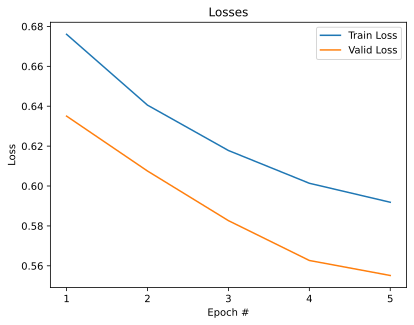

In [ ]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

## Predictions

In [ ]:
from sklearn.metrics import classification_report

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch["input_ids"]
        mask = batch["attention_mask"]
        segment = batch["token_type_ids"]
        target = batch["labels"]

        # Forward pass with named arguments
        outputs = model(input_ids=inputs, attention_mask=mask, token_type_ids=segment, labels=target)

        # Get logits
        logits = outputs.logits

        # Move logits and target to CPU and convert to numpy
        logits = logits.detach().cpu().numpy()
        target = target.cpu().numpy()

        # Get predictions and add to lists
        predictions = np.argmax(logits, axis=1)
        y_pred.extend(predictions)
        y_true.extend(target)

# Print the classification report
print(classification_report(y_true, y_pred))


Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batc

In [ ]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
inputs_lst, mask_lst, segment_lst, target_lst, text_lst = zip(*[(batch['input_ids'], batch['attention_mask'], batch['token_type_ids'], batch['labels'], batch['text']) for batch in test_loader])

# Flatten the lists of examples
inputs_lst = flatten(inputs_lst)
mask_lst = flatten(mask_lst)
segment_lst = flatten(segment_lst)
target_lst = flatten(target_lst)
text_lst = flatten(text_lst)

# Combine into a single list of test examples
test_examples = list(zip(inputs_lst, mask_lst, segment_lst, target_lst, text_lst))

def print_random_prediction(n=10):
    to_emoji = lambda x: '😄' if x == 1 else '😡'
    model.eval()
    rows = []
    for _ in range(n):
        with torch.no_grad():
            inputs, mask, segment, target, text = random.choice(test_examples)

            # Reshape tensors for model input
            inputs = inputs.unsqueeze(0).to(device)
            mask = mask.unsqueeze(0).to(device)
            segment = segment.unsqueeze(0).to(device)

            # Forward pass to get logits
            outputs = model(input_ids=inputs, attention_mask=mask, token_type_ids=segment)
            logits = outputs.logits
            prediction = torch.argmax(logits, dim=1).item()

            # Convert predictions and target to emoji for display
            predicted = to_emoji(prediction)
            actual = to_emoji(target.item())

            # Generate HTML row for display
            row = f"""
            <tr>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)

    # Construct HTML table for display
    rows_joined = '\n'.join(rows)
    table = f"""
    <table>
    <tbody>
    <tr>
    <td><b>Review</b>&nbsp;</td>
    <td><b>Predicted</b>&nbsp;</td>
    <td><b>Actual</b>&nbsp;</td>
    </tr>
    {rows_joined}
    </tbody>
    </table>
    """
    display(HTML(table))


Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batch keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'text'])
Input IDs shape: torch.Size([32, 128])
Attention mask shape: torch.Size([32, 128])
Token type IDs shape: torch.Size([32, 128])
Labels shape: torch.Size([32])
Batc

In [ ]:
print_random_prediction(n=5)

Review,Predicted,Actual
"Some moron who read or saw some reference to angels coming to Earth, decided to disregard what he'd heard about the offspring of humans and angels being larger than normal humans. Reinventing them as mythical giants that were 40 feet tall, is beyond ridiculous. There was some historical references to housing and furniture in parts of the world, that were much larger than would be needed for standard humans. These were supposedly built on a scale that would lend itself to a 10 to 14 foot human, somewhat supporting the \David and Goliath\"" tale from the bible. There is no mention in any historical references to buildings or artifacts that would support the idea of a 40 foot tall being. If I was rating this movie on my own scale, it would have been a negative value instead of a one...""",😡,😡
"This movie documents the Harlem ball circuit of the mid eighties. Much more fun than than Palazzo Volpi, though just as diseased, this movie is a true gem of squalor. One cannot help but sympathize with the characters because of their freakness . The sole purpose of middle class intellectuals is to document the phenomenons of the trash and the glitz. Here the most genius of trash is extremely well documented and duly glamorized. The characters' penchant for idolatry of all that is glamorous inspires even more adoration of the characters themselves on part of the viewer, creating a \phenomenon of a phenomenon\"" effect which makes this movie a piece of art.""",😄,😄
"The movie is a bit \thin\"" after reading the book, but it's still one of the greatest movies ever made. Sheryl Lee is beautiful and Nick Nolte is really \""vonneguty\"". He makes great job expressing the feelings from the book to the film. Not many films engage the feeling of the book as well as Mother Night does.""",😄,😄
"Brutal, emotionless Michael Myers stabs his sister to death at age six on Halloween night in 1963; on October 30, 1978, he escapes from a mental institution and institutes a new reign of terror in his hometown of Haddonfield, Illinois. He is pursued the whole time by a psychiatrist (Donald Pleasence) who knows just how evil this young man is.It opens with a bang, and sets up a genuinely suspenseful and atmospheric chiller that is actually superior to the many slasher pictures it helped to inspire. It's subtle compared to the nasty bloodbaths many of those subsequent movies were; subtle, and scary. It retains the ability to make me jump even after repeated viewings. How many movies are there, really, that can continue to be frightening even after one has seen them before? Not very many.Pleasence is great in what was probably the definitive role of his career; Jamie Lee Curtis, in her motion picture debut, became a bona fide scream queen after acting in \Halloween\"" as well as a few subsequent slasher pictures, and she is an intended victim worth rooting for.Co-writer / director John Carpenter knows what works in this movie, making excellent use of shadows and dark skies; notice how most of the movie is set after nightfall. With this picture, he and his former collaborator Debra Hill created a franchise that has spawned seven sequels, many imitators, and an upcoming \""re-imagining\"".It's very quotable - who could ever forget Dr. Loomis' (Pleasence) speech in which he describes Michael Myers to the sheriff (Charles Cyphers, a reliable repertory player in several of Carpenter's earlier works)?It's fantastic, and worth seeking out. This is my favorite John Carpenter movie of all time.It's not totally infallible - there are script holes, after all - but overall it makes a solid impact.9/10""",😡,😄
"I must have been in a good mood to give this shameful, predictable, embarrassing movie even a 3. What's wrong with it? Let's start with the gratuitous sex although I admit the rotational style of bonking was something I had not seen (nor experienced) before. And I guess they also saved a few bucks by showing the same sex scene three times. Then th